# Building a Goodreads recommendation system
**Capstone Project 2 Milestone Report 1**

In [1]:
# Import libraries
# ----------------

# Pandas
import pandas as pd

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Numpy
import numpy as np

## Background

Goodreads is a social media platform that allows users (aka readers) to rate and review books as well as see what their friends are reading, rating, and reviewing. Readers can store books on ‘shelves’ based on what they’ve read or what they want to read. They can also create custom shelves to organize their book lists however they please. 

Currently, the Goodreads recommendation system uses a reader’s shelves to suggest books they might be interested in reading next. However, the system is rudimentary and does not offer helpful suggestions since most of the books it recommends are obscure and uninteresting to the reader.

Is it possible to create a more useful recommendation system for readers? 

## The Data 

To answer this question I will be using the Goodbooks __[datasets](https://github.com/zygmuntz/goodbooks-10k)__ provided by Github user __[zygmuntz](https://github.com/zygmuntz)__. 

The Goodbooks dataset includes over six million ratings of ten thousand books on Goodreads. It is separated into three different files 

* **Ratings:** Contains nearly 6 million user ratings from 53424 users 
* **To-Read:** Contains nearly 1 million books that users added to their 'to-read' shelf 
* **Books:** Contains all of the meta data for 10,000 books. The metadata includes: title, author, number of ratings, number of each type of rating, and more 

To start, I will load each dataset into a separate dataframe so that I can clean the data before merging it into a single dataframe.

In [2]:
# Load ratings.csv
raw_ratings = "../data/raw/ratings.csv"
ratings = pd.read_csv(raw_ratings)
print('Ratings shape: {}'.format(ratings.shape))

# Load to_read.csv
raw_toread = "../data/raw/to_read.csv"
to_read = pd.read_csv(raw_toread)
print('To-Read shape: {}'.format(to_read.shape))

# Load books.csv
raw_books = "../data/raw/books.csv"
books = pd.read_csv(raw_books)
print('Books shape: {}'.format(books.shape))

Ratings shape: (5976479, 3)
To-Read shape: (912705, 2)
Books shape: (10000, 23)


### Data Cleaning

The ratings and to_read datasets were both clean with no missing data. This left the books dataset for cleaning and prep:

In [3]:
# Drop columns not of interest
books = books.drop('isbn', 1)
books = books.drop('isbn13', 1)
books = books.drop('image_url', 1)
books = books.drop('small_image_url', 1)

# Fill in the missing publication years with the year 1984
## Since this is a datetime and not a float it does not matter what year I give these missing values
books.original_publication_year = books.original_publication_year.fillna(1984)

# Replace missing original_title features with info from title
books.original_title.fillna(books.title, inplace=True)

# Replace missing language codes with 'unknown'
books.language_code = books.language_code.fillna('unknown')

# Create column for a user's average rating
ratings['avg_rating_by_user'] = ratings['rating'].groupby(ratings['user_id']).transform('mean')

# Create a column that counts the number of ratings per user
ratings['number_ratings_per_user'] = ratings['user_id'].groupby(ratings['user_id']).transform('count') 

### Data Merging
Now I am ready to start merging the dataframes. First I will merge the ratings and books dataframes:

In [4]:
# Merge ratings and books
read = pd.merge(ratings, books)

# Create a column that says whether a user has read a particular book 
# Fill all books from the read dataframe as 'read'
read['read_unread'] = 'read'

# Merge to_read with books
toread = pd.merge(to_read, books)

# Create a read_unread column to note which rows came from the to_read dataframe
toread['read_unread'] = np.nan

# Concatenate read and to_read dataframes
df = read.append(toread, sort=True)
print('DataFrame shape: {}'.format(df.shape))

# replace NaNs in read_unread with 'to_read'
df.read_unread = df['read_unread'].fillna('to read')

DataFrame shape: (6889184, 24)


Now that the three datasets have been merged into a single dataset, I need to reduce the amount of data I will be working with since I do not wish to work with a data frame that has over 6 million rows. I will filter the data to include users that have rated over 145 books and books that have at least 100,000 reviews. 

In [5]:
# Filter the dataset to users with more than 145 ratings  
df = df[df['number_ratings_per_user'] > 145]
df = df.drop('number_ratings_per_user', 1)
print('Number of reviewers in dataset:', len(df.user_id.value_counts()))

# Filter the dataframe for books that have at least 100,000 ratings
df = df[df['work_ratings_count'] > 100000 ]
print('Number of books in dataframe:', len(df.title.value_counts()))

print('DataFrame shape: {}'.format(df.shape))

Number of reviewers in dataset: 5423
Number of books in dataframe: 1049
DataFrame shape: (504756, 23)


## Visualization


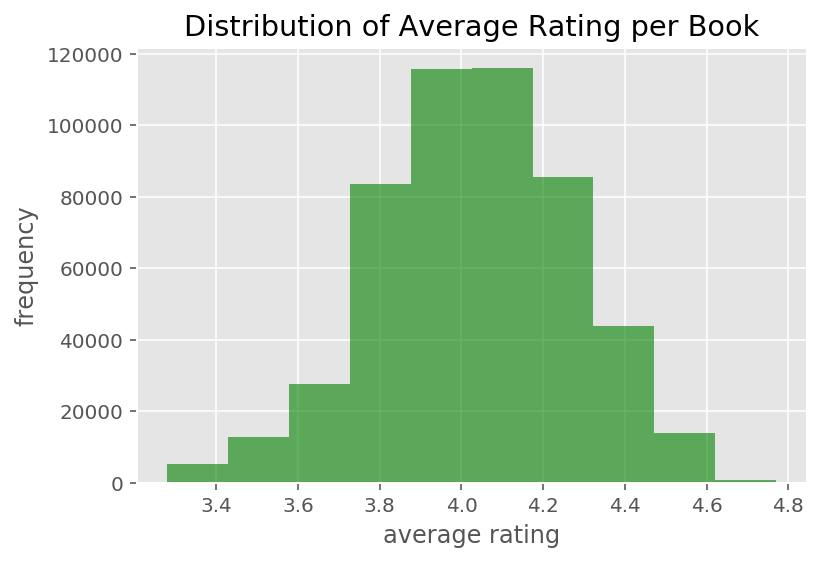

In [12]:
# Look at the distribution of average ratings per book  
plt.hist(df.average_rating, alpha = 0.6, color='g')
plt.xlabel('average rating')
plt.ylabel('frequency')
plt.title('Distribution of Average Rating per Book')
plt.show()

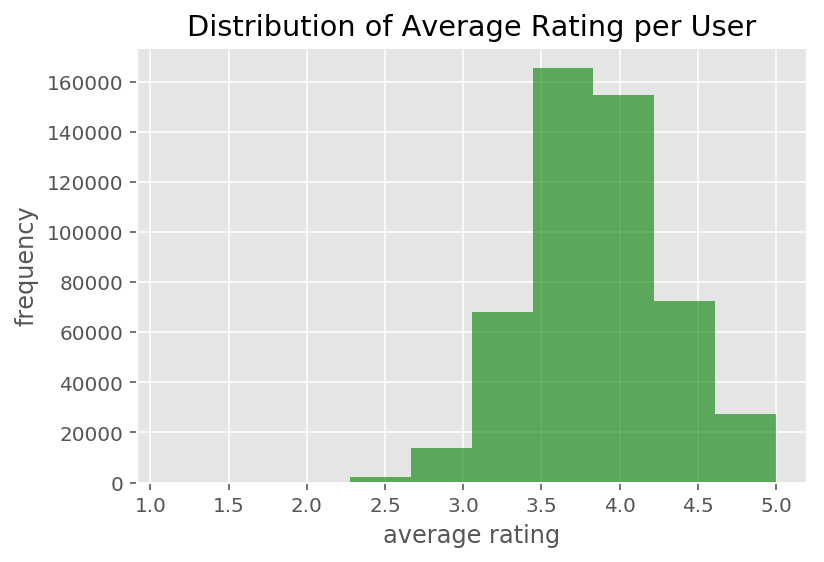

In [11]:
# Look at the distribution of the average rating per user 
plt.hist(df.avg_rating_by_user, alpha = 0.6, color='g')
plt.xlabel('average rating')
plt.ylabel('frequency')
plt.title('Distribution of Average Rating per User')
plt.show()

## Next Steps

Now that the data has been merged, cleaned, and explored my next steps are to use item-item collaborative filtering, user-user collaborative filtering, and Single Value Decomposition to see which one creates the simplest and strongest model for prediction. 